<a href="https://colab.research.google.com/github/AndrzejOlejniczak/PORTFOLIO/blob/main/BullionPredict_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BullionPredict: Time series forecasting for gold price.
## PART TWO
This Project is based on a milestone project by D. Bourke. You can access it taking this Udemy course:
https://www.udemy.com/course/tensorflow-developer-certificate-machine-learning-zero-to-mastery/.
<p> I chose to use gold price data instead of Bitcoin data. I also used scikeras package to tune hyperparameters.

In [ ]:
# Import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [ ]:
from tensorflow.keras.layers import Dense, Input, subtract, add

## 11. Model 7: N-BEATS model
Below is an implementation of: https://arxiv.org/abs/1905.10437

### 11.1. Build and test a basic block

In [ ]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(
      self,
      input_size: int,
      theta_size: int,
      horizon: int,
      n_neurons: int,
      n_layers: int,
      **kwargs,
      ):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stacj of 4 fully connected layers each has ReLU activation
    self.hidden = [Dense(self.n_neurons, activation='relu') for _ in range(self.n_layers)]

    # Output of block os a theta layer with linear activation
    self.theta_layer = Dense(theta_size, activation='linear', name='theta')

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)

    # Output backcast and forecast
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [ ]:
WINDOW_SIZE = 7
HORIZON = 1

# Instantiate test NBeatsBlock
test_nbeats_block_layer = NBeatsBlock(
    input_size = WINDOW_SIZE,
    theta_size = WINDOW_SIZE + HORIZON,
    horizon = HORIZON,
    n_neurons = 128,
    n_layers= 4
)

In [ ]:
# Create dummy inputs
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis = 0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [ ]:
# Test the block
backcast_test, forecast_test = test_nbeats_block_layer(dummy_inputs)

In [ ]:
backcast_test, forecast_test

(<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
 array([[ 0.13486496, -0.18187809, -0.9211999 ,  0.11451099,  0.639758  ,
          0.75590086,  0.57438695]], dtype=float32)>,
 <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.03706408]], dtype=float32)>)

### 11.2. Prepare the dataset

#### 11.2.1. Install and import yfinance

In [ ]:
!pip install yfinance

In [ ]:
import yfinance as yf

#### 11.2.2. Download the data

In [ ]:
df = yf.download('GC=F', auto_adjust=True)

[*********************100%***********************]  1 of 1 completed


In [ ]:
GLD_object = yf.Ticker('GC=F')

In [ ]:
GLD_object.fast_info['currency']

'USD'

In [ ]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2000-08-30,273.899994,273.899994,273.899994,273.899994,0
2000-08-31,274.799988,278.299988,274.799988,278.299988,0
2000-09-01,277.000000,277.000000,277.000000,277.000000,0
2000-09-05,275.799988,275.799988,275.799988,275.799988,2
2000-09-06,274.200012,274.200012,274.200012,274.200012,0
...,...,...,...,...,...
2023-07-18,1968.800049,1978.400024,1963.400024,1977.199951,83
2023-07-19,1977.000000,1977.500000,1973.000000,1977.500000,35
2023-07-20,1973.699951,1973.699951,1965.599976,1968.300049,638


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5743 entries, 2000-08-30 to 2023-07-24
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5743 non-null   float64
 1   High    5743 non-null   float64
 2   Low     5743 non-null   float64
 3   Close   5743 non-null   float64
 4   Volume  5743 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 269.2 KB


In [ ]:
gold_close = df.Close

In [ ]:
# Drop the timestamp information
gold_close.index = gold_close.index.date

In [ ]:
gold_close.index.set_names('Date', inplace=True)

In [ ]:
gold_close_df = gold_close.to_frame().dropna()

In [ ]:
# Create a dataset dedicated for N-BEATS model
gold_close_df_windowed = gold_close_df.copy()

#### 11.2.3. Create the dataset

In [ ]:
# Add windowed columns
for i in range(WINDOW_SIZE):
  gold_close_df_windowed[f'Close+{i+1}'] = gold_close_df_windowed['Close'].shift(periods=i+1)

In [ ]:
gold_close_df_windowed.head(8)

,Close,Close+1,Close+2,Close+3,Close+4,Close+5,Close+6,Close+7
Date,,,,,,,,
2000-08-30,273.899994,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-08-31,278.299988,273.899994,NaN,NaN,NaN,NaN,NaN,NaN
2000-09-01,277.000000,278.299988,273.899994,NaN,NaN,NaN,NaN,NaN
2000-09-05,275.799988,277.000000,278.299988,273.899994,NaN,NaN,NaN,NaN
2000-09-06,274.200012,275.799988,277.000000,278.299988,273.899994,NaN,NaN,NaN
2000-09-07,274.000000,274.200012,275.799988,277.000000,278.299988,273.899994,NaN,NaN
2000-09-08,273.299988,274.000000,274.200012,275.799988,277.000000,278.299988,273.899994,NaN
2000-09-11,273.100006,273.299988,274.000000,274.200012,275.799988,277.000000,278.299988,273.899994


In [ ]:
# Create feature and label datasets
X = gold_close_df_windowed.dropna().drop('Close', axis=1)
y = gold_close_df_windowed.dropna()['Close']

In [ ]:
X.shape, y.shape

((5736, 7), (5736,))

In [ ]:
# Create train and test sets
SPLIT_SIZE = int(len(X) * 0.8)

X_train, y_train = X[:SPLIT_SIZE], y[:SPLIT_SIZE]
X_test, y_test = X[SPLIT_SIZE:], y[SPLIT_SIZE:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4588, 7), (4588,), (1148, 7), (1148,))

In [ ]:
# Use tf.data API to create Dataset objects
X_train_dataset = tf.data.Dataset.from_tensor_slices(X_train)
y_train_dataset = tf.data.Dataset.from_tensor_slices(y_train)
X_test_dataset = tf.data.Dataset.from_tensor_slices(X_test)
y_test_dataset = tf.data.Dataset.from_tensor_slices(y_test)

In [ ]:
# Create features-label datasets
train_dataset = tf.data.Dataset.zip((X_train_dataset, y_train_dataset))
test_dataset = tf.data.Dataset.zip((X_test_dataset, y_test_dataset))

In [ ]:
# batch and prefetch datasets
BATCH_SIZE = 1024 # from N-BEATS paper

train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### 11.3. Build N-BEATS model

#### 11.3.1. Setup hyperparameters
Hyperparameters are drawn from Table 18.

In [ ]:
# Values from N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

#### 11.3.2. Build the model
We assume that a there is only one block in the stack.

In [ ]:
%%time

# Create an instance of basic block
nbeats_block = NBeatsBlock(input_size=INPUT_SIZE,
                           theta_size=THETA_SIZE,
                           horizon=HORIZON,
                           n_neurons=N_NEURONS,
                           n_layers=N_LAYERS,
                           name='basic_block'
                           )

# Create Input block
stack_input = Input(shape=(INPUT_SIZE), name='stack_input')


# Create initial residual and forecast
residuals, forecast = nbeats_block(stack_input)

# Create stacks of basic blocks
for i, _ in enumerate(range(N_STACKS - 1)):

  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f'NBeatsBlock_{i}'
  )(residuals)

  # Create double residual stacking
  residuals = subtract([residuals, backcast], name=f'subtract_{i}')
  forecast = add([forecast, block_forecast], name=f'add_{i}')

# Instantiate the stack model

model_7 = tf.keras.Model(
    inputs = stack_input,
    outputs = forecast,
    name='model_7_nbeats'
)

CPU times: user 1.53 s, sys: 21.7 ms, total: 1.55 s
Wall time: 1.51 s


In [ ]:
# Compile the model

model_7.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

In [ ]:
model_7.summary()

Model: "model_7_nbeats"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 stack_input (InputLayer)       [(None, 7)]          0           []                               
                                                                                                  
 basic_block (NBeatsBlock)      ((None, 7),          796168      ['stack_input[0][0]']            
                                 (None, 1))                                                       
                                                                                                  
 NBeatsBlock_0 (NBeatsBlock)    ((None, 7),          796168      ['basic_block[0][0]']            
                                 (None, 1))                                                       
                                                                                     

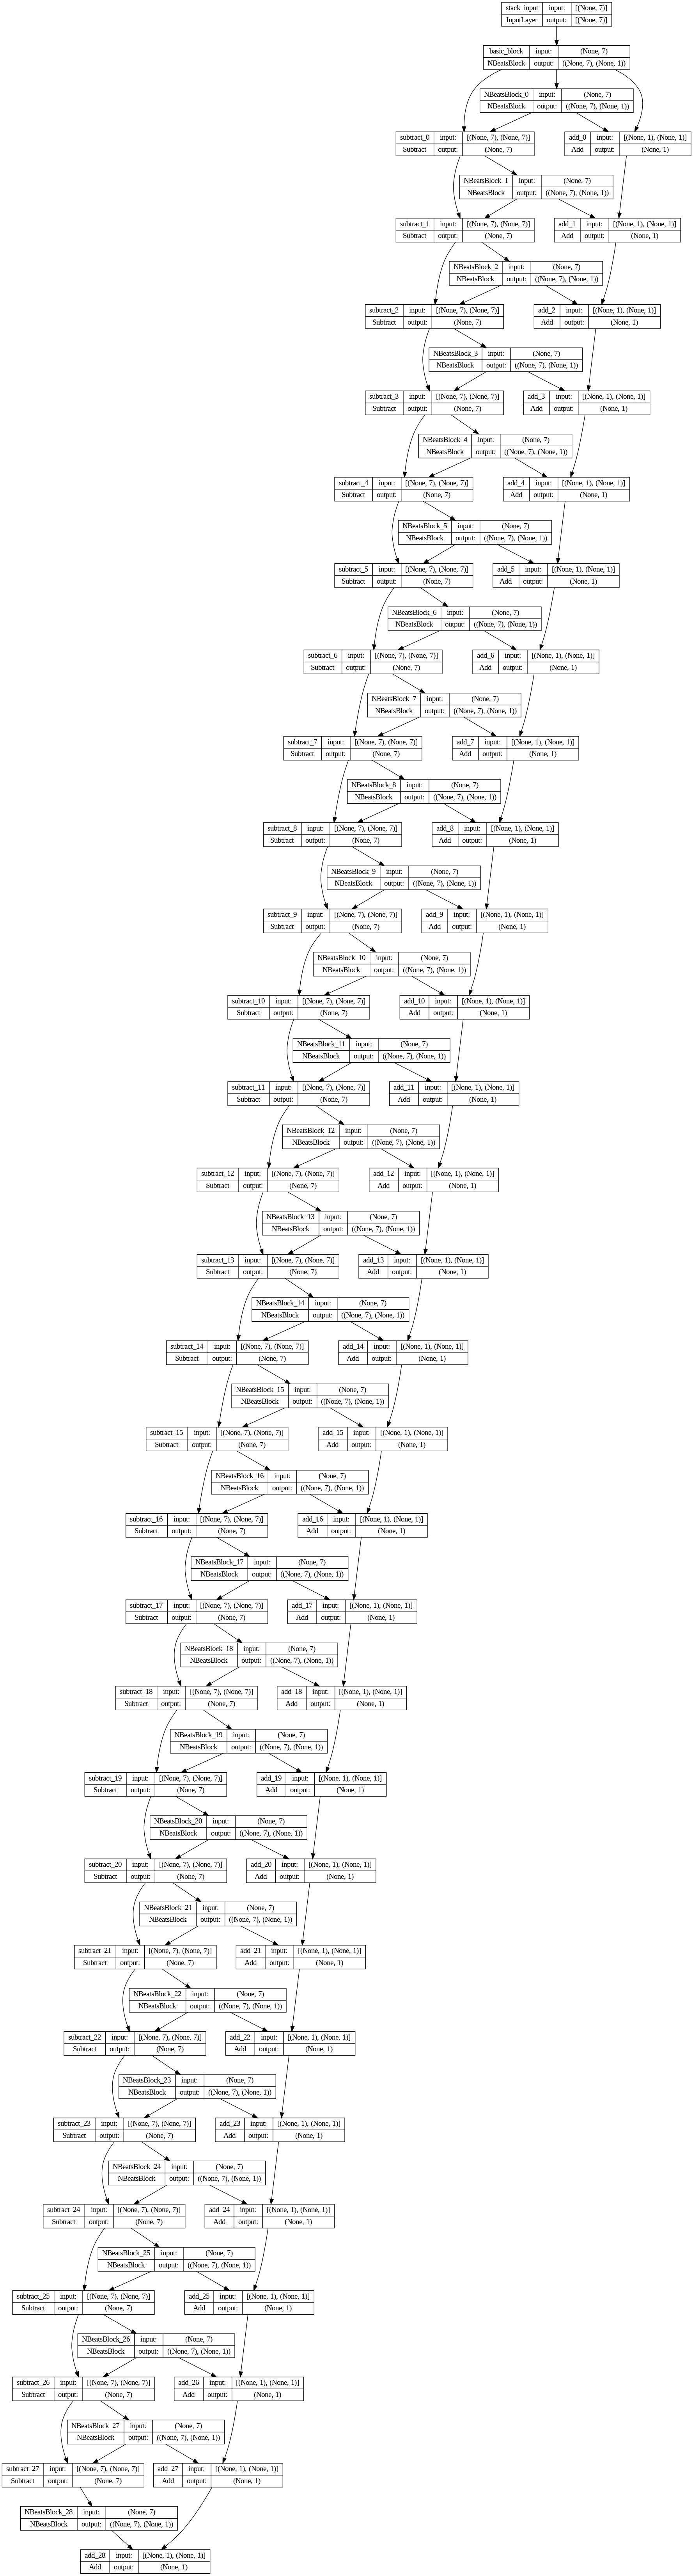

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_7, show_shapes=True )

In [ ]:
%%time
# Fit the model with early stopping and reduce learning rate at plateau

history_7 = model_7.fit(train_dataset,
                        epochs=N_EPOCHS,
                        validation_data=test_dataset,
                        verbose=0,
                        callbacks=[
                            tf.keras.callbacks.EarlyStopping(
                                monitor='val_loss',
                                patience=200,
                                restore_best_weights=True),
                            tf.keras.callbacks.ReduceLROnPlateau(
                                monitor='val_loss',
                                patience=100,
                                verbose=1)
                            ])


Epoch 691: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
CPU times: user 24min 39s, sys: 38.5 s, total: 25min 18s
Wall time: 26min 56s


### 11.4. Evaluate the model

In [ ]:
model_7.evaluate(test_dataset)

2/2 [==============================] - 0s 10ms/step - loss: 12.5640


12.5640230178833

In [ ]:
def make_preds(model, input_data):
  '''
  Uses model to make predictions on input_data
  '''
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)

def produce_metrics(y_true, y_pred):
  # Mean absolute error
  mae = tf.reduce_mean(tf.abs(y_pred-y_true))

  # Mean absolute error of naive forecast no seasonality
  mae_naive = tf.reduce_mean(tf.abs(y_true[:-1] - y_true[1:]))

  # Mean squared error
  mse = tf.reduce_mean((y_pred-y_true)**2)

  # Root mean squared error
  rmse = tf.math.sqrt(tf.reduce_mean((y_pred-y_true)**2))

  # Mean absolute percentage error
  mape = tf.reduce_mean((tf.abs((y_pred - y_true) / y_true)*100))

  # Symmetric mean absolute percentage error
  smape = tf.reduce_mean(200*(tf.abs(y_pred - y_true)/(y_true + y_pred)))

  # Mean absolute scaled error
  mase = mae / mae_naive

  # Return dictionary

  return {
      'mae': mae.numpy(),
      'mse': mse.numpy(),
      'rmse': rmse.numpy(),
      'mape': mape.numpy(),
      'smape': smape.numpy(),
      'mase': mase.numpy()
  }


In [ ]:
model_7_preds = make_preds(model_7, test_dataset)

2/2 [==============================] - 1s 14ms/step


In [ ]:
tf.stack(list(y_test), axis=0)

<tf.Tensor: shape=(1148,), dtype=float32, numpy=array([1278.3, 1281. , 1291.8, ..., 1968.3, 1964.3, 1962. ], dtype=float32)>

In [ ]:
model_7_results = produce_metrics(tf.cast(tf.stack(list(y_test), axis=0), dtype=tf.float32).numpy(), model_7_preds)

In [ ]:
model_7_results

{'mae': 12.564023,
 'mse': 322.14856,
 'rmse': 17.948498,
 'mape': 0.7229476,
 'smape': 0.72240496,
 'mase': 1.0183325}

## 12. Model 8: Ensamble model

In [ ]:
HORIZON, WINDOW_SIZE

(1, 7)

### 12.1. Define a function returning an ensemble of models

In [ ]:
def get_ensemble(
    horizo=HORIZON,
    train_data=train_dataset,
    test_data=test_dataset,
    num_iter=10,
    num_epochs=1000,
    loss_fns=['mae', 'mse', 'mape']
    ):
  '''
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.
  '''

  # make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):

    # Build and fit a new model with different loss function
    for loss_function in loss_fns:
      print(f'Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}')

      # Construct a simple model
      model = tf.keras.Sequential([
          Dense(128, kernel_initializer='he_normal', activation='relu'),
          Dense(128, kernel_initializer='he_normal', activation='relu'),
          Dense(HORIZON)
      ])

      # Compile the model
      model.compile(
          loss=loss_function,
          optimizer=tf.keras.optimizers.Adam(),
          metrics=['mae', 'mse', 'mape']
      )

      # Fit the model
      model.fit(
          train_data,
          validation_data=test_data,
          verbose=0,
          epochs=num_epochs,
          callbacks=[
              tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True),
              tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, verbose=1)
          ]
      )

      # Append ensemble model list
      ensemble_models.append(model)

  return ensemble_models

### 12.2. Create first ensemble of models

In [ ]:
%%time
# Get a list of trained ensemble models
ensemble_models_1 = get_ensemble(num_iter=5, num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 155: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 0
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 149: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 118: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 505: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 605: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 1

Epoch 132: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 342: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae fo

In [ ]:
ensemble_models_1

### 12.3. Define function returning a list of predictions and a averaged prediction

In [ ]:
def predict_with_ensemble(ensemble, data):
  '''
  Returns tuple (predictions for each model, mean averaged prediction)
  after applying model.predict() method on each item from a list of models.
  '''

  ensemble_preds = []

  for model in ensemble:
    preds = model.predict(data)
    ensemble_preds.append(preds)

  return (tf.constant(tf.squeeze(ensemble_preds)) , tf.constant(tf.squeeze( tf.reduce_mean(ensemble_preds, axis=0))))

In [ ]:
list_of_preds, mean_preds = predict_with_ensemble(ensemble_models_1, test_dataset)

2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


2/2 [==============================] - 0s 4ms/step


In [ ]:
list_of_preds

<tf.Tensor: shape=(15, 1148), dtype=float32, numpy=
array([[1284.5468, 1278.9308, 1283.5803, ..., 1986.5396, 1969.3677,
        1971.3372],
       [1281.8318, 1273.8303, 1282.1774, ..., 1977.2013, 1968.7074,
        1964.7704],
       [1283.4813, 1276.8857, 1284.6934, ..., 1985.4272, 1969.7103,
        1967.4277],
       ...,
       [1279.0483, 1283.9869, 1282.373 , ..., 1958.6396, 1976.1816,
        1980.0156],
       [1275.2106, 1274.8895, 1282.695 , ..., 1980.9862, 1967.7533,
        1961.4459],
       [1273.7444, 1286.1705, 1277.7491, ..., 1963.3599, 1973.4205,
        1967.2112]], dtype=float32)>

In [ ]:
mean_preds

<tf.Tensor: shape=(1148,), dtype=float32, numpy=
array([1279.5214, 1279.1187, 1281.2327, ..., 1975.5676, 1971.5764,
       1967.8737], dtype=float32)>

In [ ]:
# Define a function reaturning a dictionary with all the above metrics
def produce_metrics(y_true, y_pred):
  # Mean absolute error
  mae = tf.reduce_mean(tf.abs(y_pred-y_true))

  # Mean absolute error of naive forecast no seasonality
  mae_naive = tf.reduce_mean(tf.abs(y_true[:-1] - y_true[1:]))

  # Mean squared error
  mse = tf.reduce_mean((y_pred-y_true)**2)

  # Root mean squared error
  rmse = tf.math.sqrt(tf.reduce_mean((y_pred-y_true)**2))

  # Mean absolute percentage error
  mape = tf.reduce_mean((tf.abs((y_pred - y_true) / y_true)*100))

  # Symmetric mean absolute percentage error
  smape = tf.reduce_mean(200*(tf.abs(y_pred - y_true)/(y_true + y_pred)))

  # Mean absolute scaled error
  mase = mae / mae_naive

  # Return dictionary

  return {
      'mae': mae.numpy(),
      'mse': mse.numpy(),
      'rmse': rmse.numpy(),
      'mape': mape.numpy(),
      'smape': smape.numpy(),
      'mase': mase.numpy()
  }


### 12.4. Evaluate the model

In [ ]:
mean_preds

<tf.Tensor: shape=(1148,), dtype=float32, numpy=
array([1279.5214, 1279.1187, 1281.2327, ..., 1975.5676, 1971.5764,
       1967.8737], dtype=float32)>

In [ ]:
produce_metrics(y_true=y_test, y_pred=tf.cast(mean_preds, tf.float64))

{'mae': 12.75788342412756,
 'mse': 331.03281982841446,
 'rmse': 18.194307346761363,
 'mape': 0.7341594903097014,
 'smape': 0.7340236882186392,
 'mase': nan}

{'mae': 12.263685045744243,
 'mse': 309.243055422408,
 'rmse': 17.585307942211532,
 'mape': 0.7111868322487799,
 'smape': 0.7111082729643075,
 'mase': 1.0003033718367385}

In [ ]:
produce_metrics(y_true=y_test, y_pred=tf.cast(np.median(list_of_preds, axis=0), tf.float64))

{'mae': 12.660868574933309,
 'mse': 324.5939831235397,
 'rmse': 18.016491976062923,
 'mape': 0.7283338567037588,
 'smape': 0.7282165177344443,
 'mase': nan}

### 12.5. Plot prediction intervals (uncertainty estimates) of the ensamble

#### Bootstrap method for specifying 95% confidence prediction intervals:

1. Collect predictions from a number of randomly initialized models or a single model.
2. Measure standard deviation of the predictions.
3. Multiply standard deviation by 1.96 (if the distribution is Gaussian, 95% of observations fall within 1.96 standard deviations of the mean)
4. Compute prediction interval upper and lower bounds by adding and subtracting the value obtained in (3) to the mean of predictions collected in (1).  

In [ ]:
list_of_preds

<tf.Tensor: shape=(15, 1148), dtype=float32, numpy=
array([[1284.5468, 1278.9308, 1283.5803, ..., 1986.5396, 1969.3677,
        1971.3372],
       [1281.8318, 1273.8303, 1282.1774, ..., 1977.2013, 1968.7074,
        1964.7704],
       [1283.4813, 1276.8857, 1284.6934, ..., 1985.4272, 1969.7103,
        1967.4277],
       ...,
       [1279.0483, 1283.9869, 1282.373 , ..., 1958.6396, 1976.1816,
        1980.0156],
       [1275.2106, 1274.8895, 1282.695 , ..., 1980.9862, 1967.7533,
        1961.4459],
       [1273.7444, 1286.1705, 1277.7491, ..., 1963.3599, 1973.4205,
        1967.2112]], dtype=float32)>

In [ ]:
import scipy.stats as stats

In [ ]:
np.random.normal(loc=tf.reduce_mean(list_of_preds, axis=0), scale=tf.math.reduce_std(list_of_preds, axis=0))

array([1277.49972154, 1281.02340524, 1278.8965517 , ..., 1954.91053114,
       1971.1547195 , 1965.52072905])

In [ ]:
lower_bound, upper_bound = stats.norm.interval(confidence=.95, loc=tf.reduce_mean(list_of_preds, axis=0), scale=tf.math.reduce_std(list_of_preds, axis=0))

In [ ]:
print(len(upper_bound), len(list_of_preds), len(lower_bound))

1148 15 1148


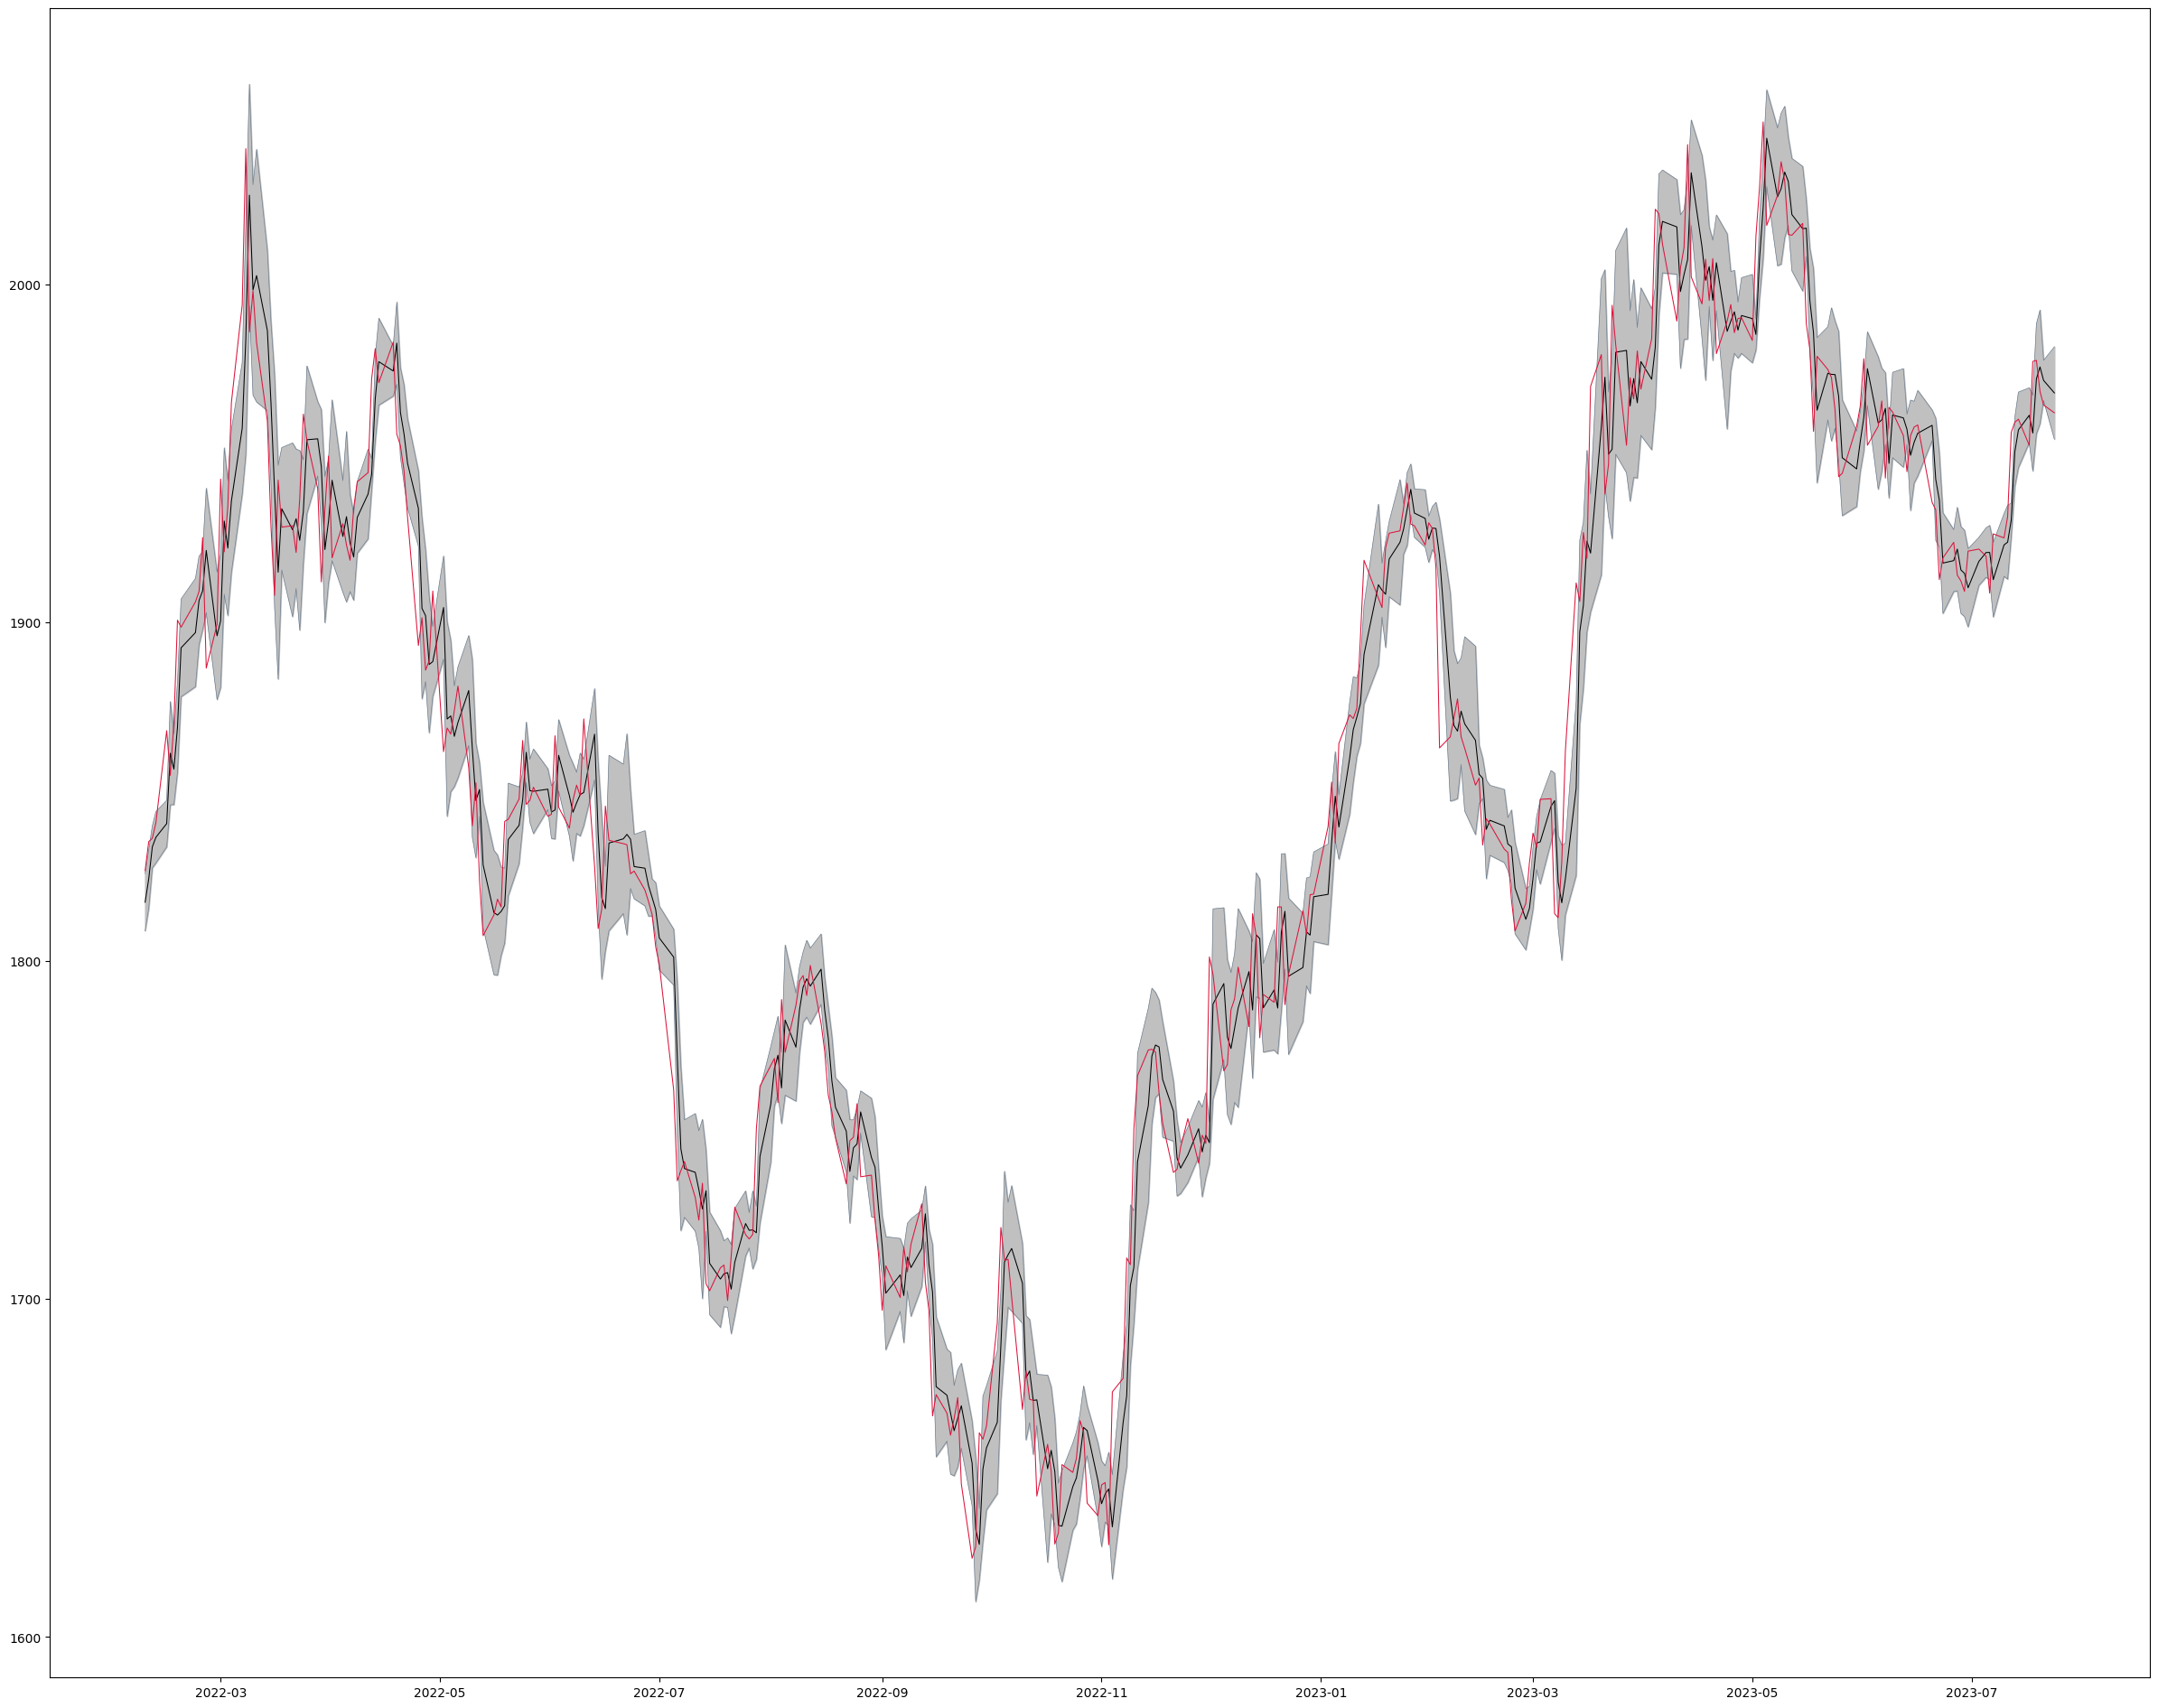

In [ ]:
fig, ax = plt.subplots(figsize=(30,24))
ax.plot(y_test.index[-365:], upper_bound[-365:], linewidth=.5, color='slategrey')
ax.plot(y_test.index[-365:], tf.reduce_mean(list_of_preds, axis=0)[-365:], linewidth=.75, color='black')
ax.plot(y_test.index[-365:], lower_bound[-365:], linewidth=.5, color='slategrey')
ax.plot(y_test.index[-365:], y_test[-365:], linewidth=.75, color='crimson')

ax.fill_between(x=y_test.index[-365:], y1=lower_bound[-365:], y2=upper_bound[-365:], color='silver')

plt.show()

In [ ]:
fig, ax

(<Figure size 3000x2400 with 1 Axes>, <Axes: >)

In [ ]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None, **kwargs):
  '''
  Plots timesteps against values

  Parameters
  ----------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : index of timesteps series
  end : index of timesteps series
  label: label to show on plot values
  '''

  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label, **kwargs)
  plt.xlabel('Time')
  plt.ylabel(f'Value')
  if label is not None:
    plt.legend(fontsize=14)
  plt.grid(True)

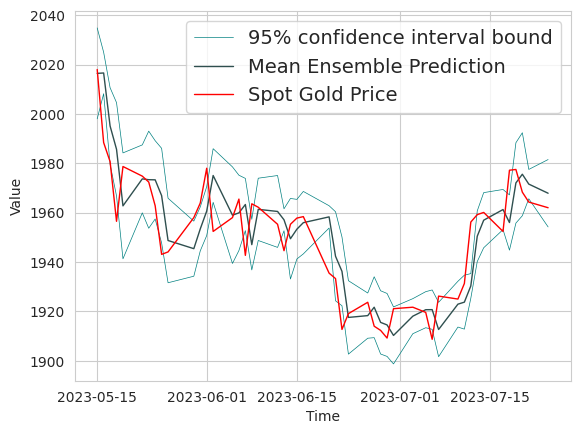

In [ ]:
sns.set_style('whitegrid')
sns.set_palette('deep')
sns.set_color_codes(palette='deep')
plot_time_series(timesteps=y_test.index, values=upper_bound, start=1100, format='-', linewidth=.5, color='teal', label='95% confidence interval bound')
plot_time_series(timesteps=y_test.index, values=tf.reduce_mean(list_of_preds, axis=0), start=1100, format='-', linewidth=1, color='darkslategrey', label='Mean Ensemble Prediction')
plot_time_series(timesteps=y_test.index, values=lower_bound, start=1100, format='-', linewidth=.5, color='teal')
plot_time_series(timesteps=y_test.index, values=y_test, start=1100, format='-', linewidth=1, color='red', label='Spot Gold Price')

In [ ]:
gold_close_df_windowed

,Close,Close+1,Close+2,Close+3,Close+4,Close+5,Close+6,Close+7
Date,,,,,,,,
2000-08-30,273.899994,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-08-31,278.299988,273.899994,NaN,NaN,NaN,NaN,NaN,NaN
2000-09-01,277.000000,278.299988,273.899994,NaN,NaN,NaN,NaN,NaN
2000-09-05,275.799988,277.000000,278.299988,273.899994,NaN,NaN,NaN,NaN
2000-09-06,274.200012,275.799988,277.000000,278.299988,273.899994,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-07-18,1977.199951,1952.400024,1960.099976,1959.199951,1956.199951,1931.300049,1925.000000,1926.199951
2023-07-19,1977.500000,1977.199951,1952.400024,1960.099976,1959.199951,1956.199951,1931.300049,1925.000000
2023-07-20,1968.300049,1977.500000,1977.199951,1952.400024,1960.099976,1959.199951,1956.199951,1931.300049


In [ ]:
len(gold_close_df_windowed)

5743

## 13. Model 8.1: NBEATS ensemble model

### 13.1. Prepare a datset for all data points

In [ ]:
# Create feature dataset
X_all = gold_close_df_windowed.dropna().drop('Close', axis=1).to_numpy()
X_all.shape

(5736, 7)

In [ ]:
# Create labels dataset
y_all = gold_close_df_windowed.dropna()['Close'].to_numpy()
y_all.shape

(5736,)

In [ ]:
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all =  tf.data.Dataset.from_tensor_slices(y_all)

In [ ]:
# Create final dataset
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

In [ ]:
# Optimize the dataset
BATCH_SIZE= 124
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

### 13.2. Redesign NBeatsBlock class
Add @staticmethod that creates a whole model using NBeatsBlock architecture.

In [ ]:
INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

In [ ]:
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(
      self,
      input_size: int,
      theta_size: int,
      horizon: int,
      n_neurons: int,
      n_layers: int,
      **kwargs,
      ):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stacj of 4 fully connected layers each has ReLU activation
    self.hidden = [Dense(self.n_neurons, activation='relu') for _ in range(self.n_layers)]

    # Output of block os a theta layer with linear activation
    self.theta_layer = Dense(theta_size, activation='linear', name='theta')

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)

    # Output backcast and forecast
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

  @staticmethod
  def generate_nbeats_model(input_size: int, theta: int, horizon: int, n_neurons: int, n_layers: int, n_stacks: int):
    '''
    Creates NBEATS-like model using hyperparameters,
    for the purpose of automatic model creation for ensemble learning.

    ...

    Attributes
    ----------

    input_size: int
      window size of the train data times horizon

    theta: int
      input_size plus horizon

    horizon: int
      horizon of the data

    n_neurons: int
      number of neurons in each basic NBEATS block layer

    n_layers: int
      number of layers in each basic NBEATS block

    n_stack: int
      number of stacks of basic NBEATS blocks

    '''

    # Create an instance of basic block
    nbeats_block = NBeatsBlock(input_size=input_size,
                              theta_size=theta,
                              horizon=horizon,
                              n_neurons=n_neurons,
                              n_layers=n_layers,
                              )

    # Create Input block
    stack_input = Input(shape=(INPUT_SIZE), name='stack_input')

    # Create initial residual and forecast
    residuals, forecast = nbeats_block(stack_input)

    # Create stacks of basic blocks
    for i, _ in enumerate(range(N_STACKS - 1)):

      backcast, block_forecast = NBeatsBlock(
          input_size=INPUT_SIZE,
          theta_size=THETA_SIZE,
          horizon=HORIZON,
          n_neurons=N_NEURONS,
          n_layers=N_LAYERS,
          name=f'NBeatsBlock_{i}'
      )(residuals)

      # Create double residual stacking
      residuals = subtract([residuals, backcast], name=f'subtract_{i}')
      forecast = add([forecast, block_forecast], name=f'add_{i}')

    # Instantiate the stack model

    model = tf.keras.Model(
        inputs = stack_input,
        outputs = forecast,
    )

    return model

In [ ]:
help(NBeatsBlock)

Help on class NBeatsBlock in module __main__:

class NBeatsBlock(keras.engine.base_layer.Layer)
 |  NBeatsBlock(input_size: int, theta_size: int, horizon: int, n_neurons: int, n_layers: int, **kwargs)
 |  
 |  Method resolution order:
 |      NBeatsBlock
 |      keras.engine.base_layer.Layer
 |      tensorflow.python.module.module.Module
 |      tensorflow.python.trackable.autotrackable.AutoTrackable
 |      tensorflow.python.trackable.base.Trackable
 |      keras.utils.version_utils.LayerVersionSelector
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, input_size: int, theta_size: int, horizon: int, n_neurons: int, n_layers: int, **kwargs)
 |  
 |  call(self, inputs)
 |      This is where the layer's logic lives.
 |      
 |      The `call()` method may not create state (except in its first
 |      invocation, wrapping the creation of variables or other resources in
 |      `tf.init_scope()`).  It is recommended to create state, including
 |      `tf.Varia

In [ ]:
def get_ensemble_2(
    model_creation_fn,
    train_data,
    test_data,
    num_iter=10,
    num_epochs=1000,
    loss_fns=['mae', 'mse', 'mape'],
    **kwargs
    ):
  '''
  Returns a list of num_iter models each trained on chosen metrics.
  '''

  # make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):

    # Build and fit a new model with different loss function
    for loss_function in loss_fns:
      print(f'Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}')

      # Create the model
      model = model_creation_fn(**kwargs)

      # Compile the model
      model.compile(
          loss=loss_function,
          optimizer=tf.keras.optimizers.Adam(),
          metrics=['mae', 'mse', 'mape']
      )

      # Fit the model
      model.fit(
          train_data,
          validation_data=test_data,
          verbose=0,
          epochs=num_epochs,
          callbacks=[
              tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True),
              tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, verbose=1)
          ]
      )

      # Append ensemble model list
      ensemble_models.append(model)

  return ensemble_models

In [ ]:
N_EPOCHS

5000

### 13.3. Train NBEATS ensemble

In [ ]:
nbeats_ensemble = get_ensemble_2(
    model_creation_fn = NBeatsBlock.generate_nbeats_model,
    train_data = train_dataset,
    test_data = test_dataset,
    num_iter=10,
    num_epochs=N_EPOCHS,
    loss_fns=['mae', 'mse', 'mape'],
    # and now kwargs for the model creation function
    input_size=7,
    theta=8,
    horizon=HORIZON,
    n_neurons=N_NEURONS,
    n_layers=N_LAYERS,
    n_stacks=N_STACKS
)

Optimizing model by reducing: mae for 5000 epochs, model number: 0

Epoch 1494: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model by reducing: mse for 5000 epochs, model number: 0

Epoch 1254: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1791: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 3032: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 3132: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.
Optimizing model by reducing: mape for 5000 epochs, model number: 0

Epoch 550: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 650: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 5000 epochs, model number: 1

Epoch 865: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 965: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimi

In [ ]:
nbeats_ensemble

In [ ]:
# Let's save this work since training took about half a day ...
for idx, model in enumerate(nbeats_ensemble):
    model.save(f'nbeats_model_{idx}.h5')

In [ ]:
saved_model_dir = '/content/drive/MyDrive/Colab Notebooks/BullionPredict models'

In [ ]:
import os

In [ ]:
os.listdir(saved_model_dir)

['nbeats_model_0.h5',
 'nbeats_model_1.h5',
 'nbeats_model_2.h5',
 'nbeats_model_3.h5',
 'nbeats_model_4.h5',
 'nbeats_model_5.h5',
 'nbeats_model_6.h5',
 'nbeats_model_7.h5',
 'nbeats_model_8.h5',
 'nbeats_model_9.h5',
 'nbeats_model_10.h5',
 'nbeats_model_11.h5',
 'nbeats_model_12.h5',
 'nbeats_model_13.h5',
 'nbeats_model_14.h5',
 'nbeats_model_15.h5',
 'nbeats_model_16.h5',
 'nbeats_model_17.h5',
 'nbeats_model_24.h5',
 'nbeats_model_18.h5',
 'nbeats_model_19.h5',
 'nbeats_model_28.h5',
 'nbeats_model_27.h5',
 'nbeats_model_20.h5',
 'nbeats_model_29.h5',
 'nbeats_model_21.h5',
 'nbeats_model_22.h5',
 'nbeats_model_23.h5',
 'nbeats_model_26.h5',
 'nbeats_model_25.h5']

In [ ]:
nbeats_ensemble_loaded = []
for model_name in os.listdir(saved_model_dir):
  loaded_model = tf.keras.models.load_model(os.path.join(saved_model_dir, model_name), custom_objects={
  'NBeatsBlock': NBeatsBlock
})
  nbeats_ensemble_loaded.append(loaded_model)

In [ ]:
nbeats_ensemble_loaded

### 13.4. Predict on ensemble and evalueate the model

In [ ]:
nbeats_list_of_preds, nbeats_mean_preds = predict_with_ensemble(nbeats_ensemble_loaded, test_dataset)

2/2 [==============================] - 1s 31ms/step


In [ ]:
produce_metrics(y_true=y_test, y_pred=tf.cast(nbeats_mean_preds, tf.float64))

{'mae': 12.780471642258275,
 'mse': 331.51906462688686,
 'rmse': 18.207664996558094,
 'mape': 0.735243255909476,
 'smape': 0.7349564467971873,
 'mase': nan}

{'mae': 12.263685045744243,
 'mse': 309.243055422408,
 'rmse': 17.585307942211532,
 'mape': 0.7111868322487799,
 'smape': 0.7111082729643075,
 'mase': 1.0003033718367385}

In [ ]:
produce_metrics(y_true=y_test, y_pred=tf.cast(np.median(nbeats_list_of_preds, axis=0), tf.float64))

{'mae': 12.401285736402983,
 'mse': 314.21446622825044,
 'rmse': 17.726095628430148,
 'mape': 0.7130005294342204,
 'smape': 0.7126709734918167,
 'mase': nan}

### 13.5. Compute and plot confidence intervals

In [ ]:
nbeats_lower, nbeats_upper = stats.norm.interval(confidence=.95, loc=tf.reduce_mean(nbeats_list_of_preds, axis=0), scale=tf.math.reduce_std(nbeats_list_of_preds, axis=0))

In [ ]:
print(
    len(nbeats_lower),
    nbeats_list_of_preds.shape,
    len(nbeats_upper),
)

1148 (30, 1148) 1148


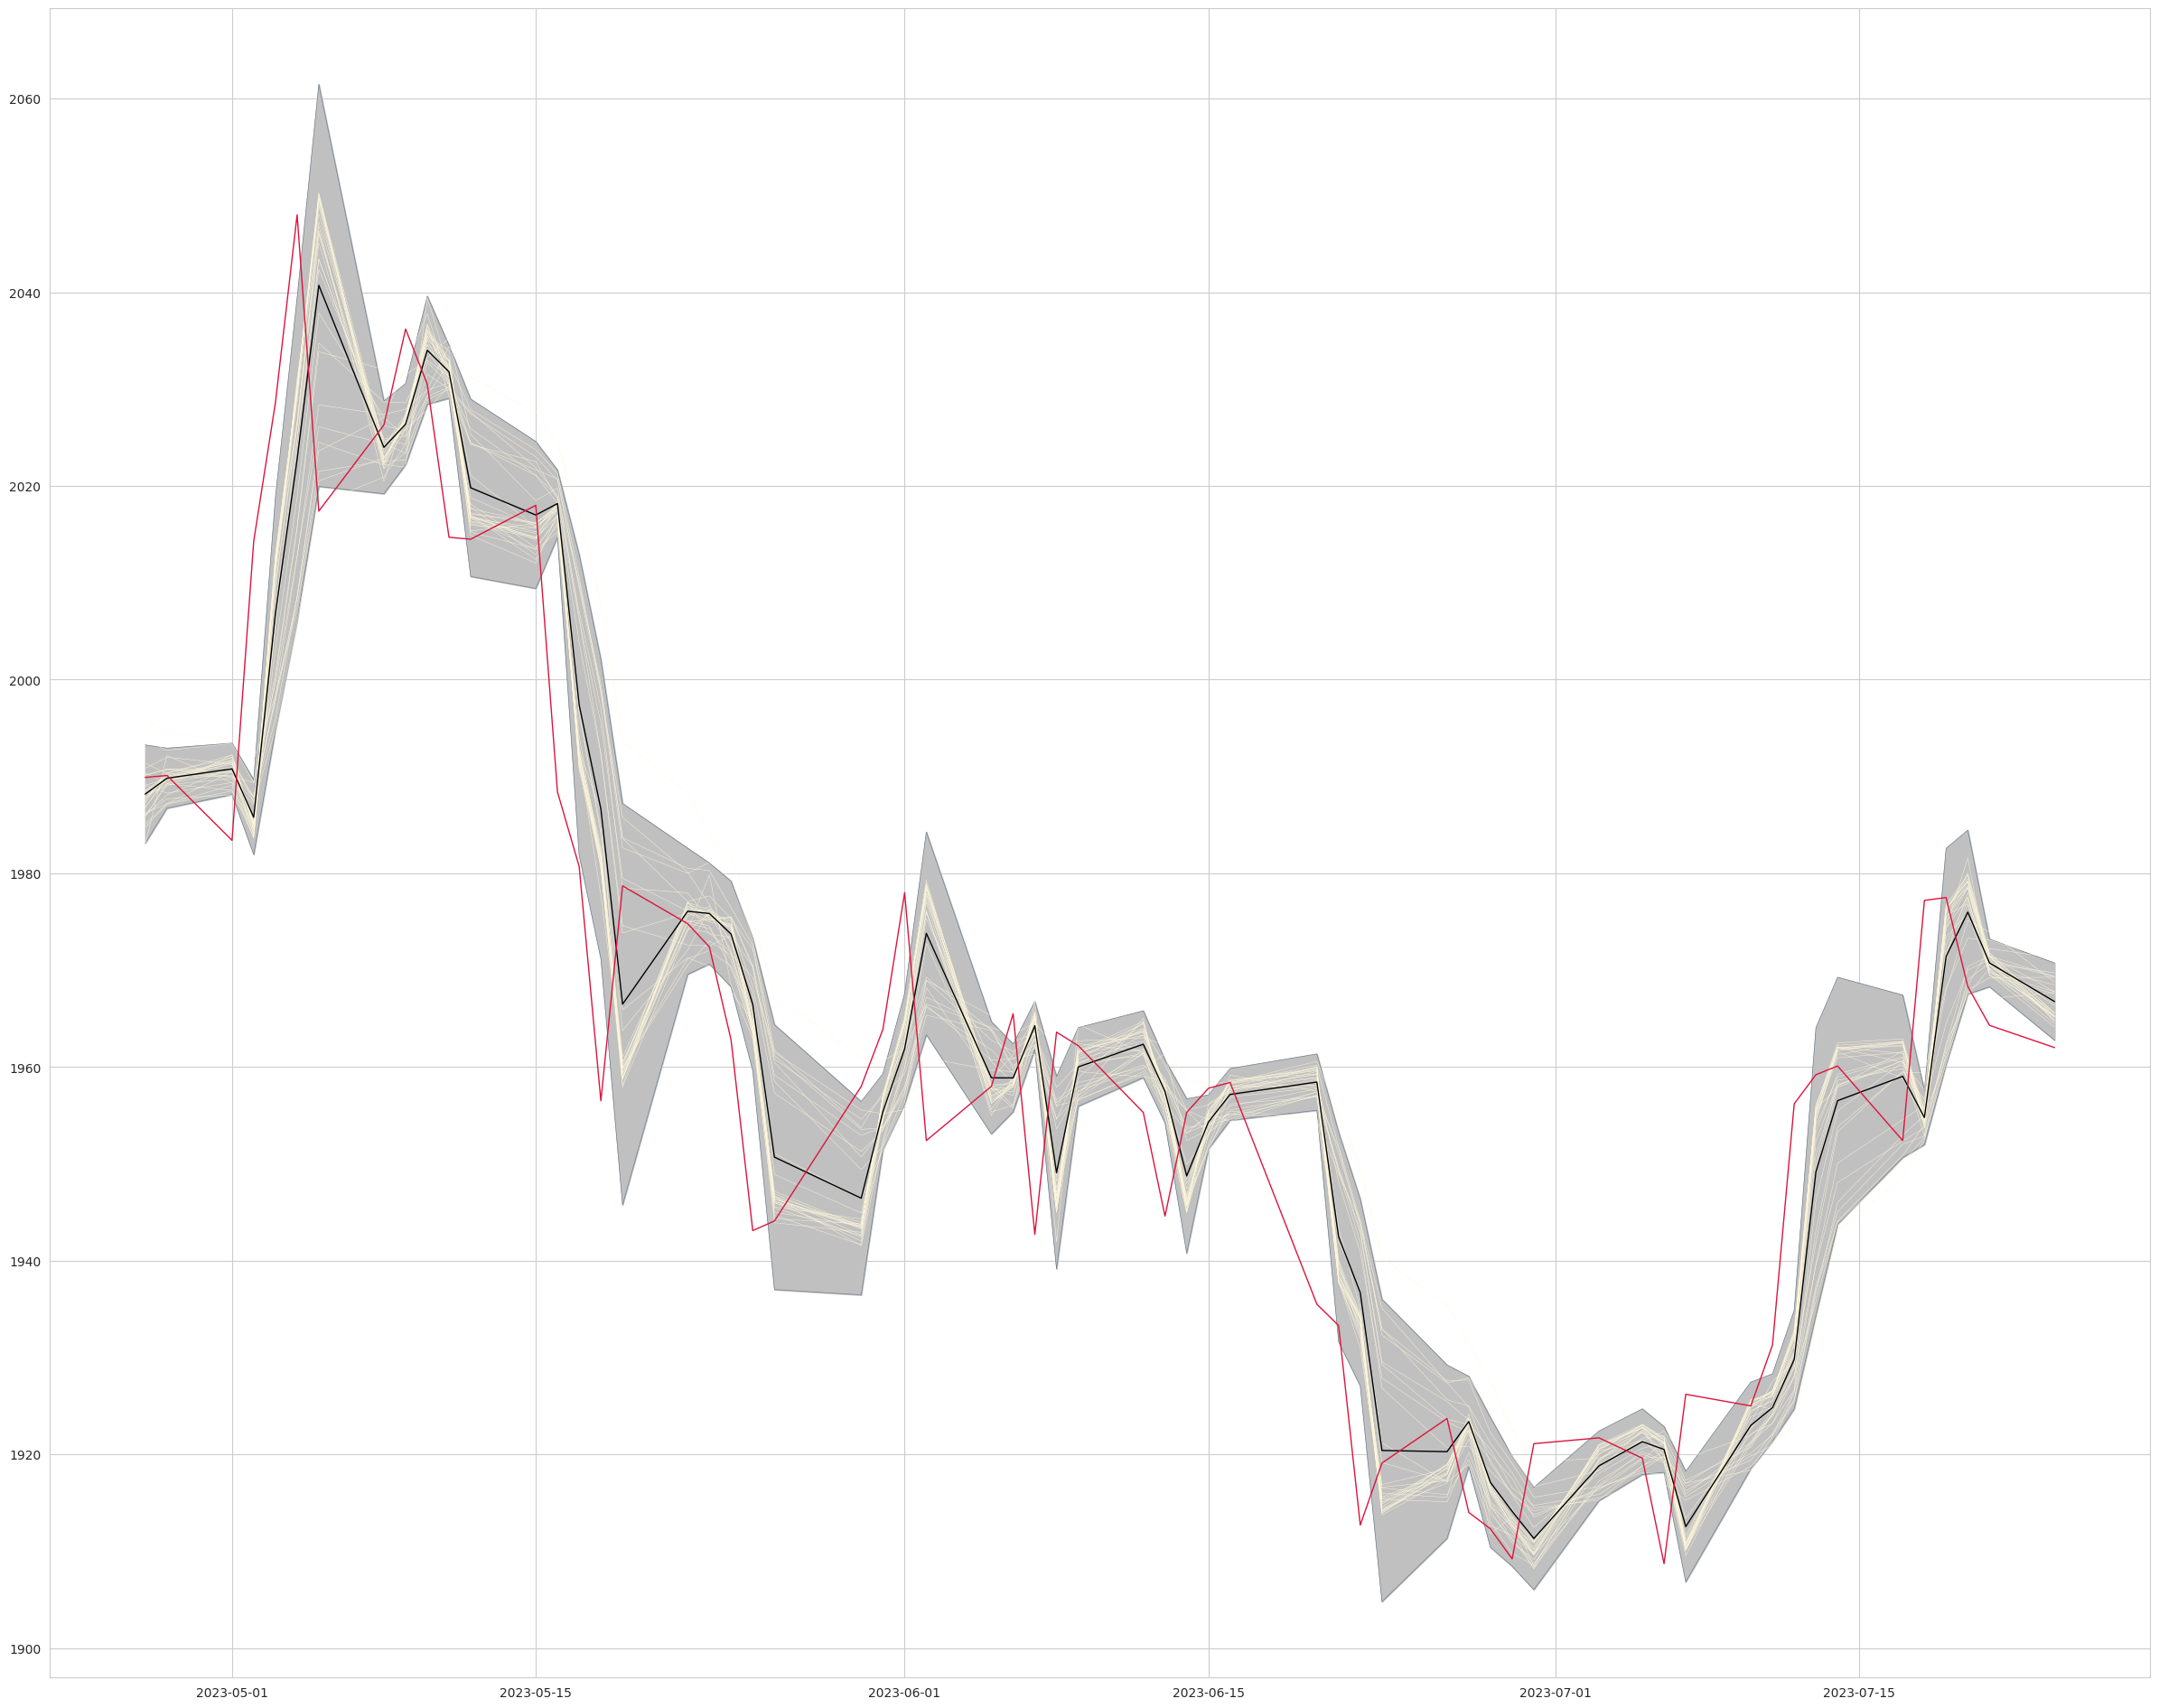

In [ ]:
fig, ax = plt.subplots(figsize=(30,24))
ax.plot(y_test.index[-60:], nbeats_upper[-60:], linewidth=.5, color='slategrey')
ax.plot(y_test.index[-60:], tf.reduce_mean(nbeats_list_of_preds, axis=0)[-60:], linewidth=1, color='black', zorder=3)
ax.plot(y_test.index[-60:], nbeats_lower[-60:], linewidth=.5, color='slategrey')
ax.plot(y_test.index[-60:], y_test[-60:], linewidth=1, color='crimson', zorder=3)

for idx, el in enumerate(nbeats_list_of_preds):
  ax.plot(y_test.index[-60:], nbeats_list_of_preds[idx, -60:], linewidth=.3, color='cornsilk')

ax.fill_between(x=y_test.index[-60:], y1=nbeats_lower[-60:], y2=nbeats_upper[-60:], color='silver')

plt.show()

## 14. Model 9: Future prediction model

In [ ]:
tf.random.set_seed(44)

# Create a test model
model_9 = tf.keras.Sequential([
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(HORIZON, activation='relu'),
])

# Compile the model
model_9.compile(
    loss='mae',
    optimizer='adam',
    metrics=['mae', 'mse']
)

In [ ]:
# Fit model on all of the data
history_9 = model_9.fit(
    dataset_all,
    epochs=100,
    verbose=0
)

In [ ]:
STEP_INTO_FUTURE = 14

In [ ]:
y_all[-WINDOW_SIZE:]

array([1960.09997559, 1952.40002441, 1977.19995117, 1977.5       ,
       1968.30004883, 1964.30004883, 1962.        ])

In [ ]:
# Define a function that takes in historic timeseries data,
# a horizon and trained model with WINDOW_SIZE model's hyperparameter
# and returns a listo of predictions of len(HORIZON)

def back_to_future(
    data,
    model,
    data_window,
    future_horizon,
) -> list:

  last_window = data[-data_window:]

  print(f'Predict usinh {model.name}')

  for _ in range(future_horizon):
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f'Predicting on:\n {last_window}n\ Prediction:n\ {tf.squeeze(future_pred).numpy()}\n')

    last_window = np.append(last_window, future_pred)[-data_window:]

  return last_window

In [ ]:
nbeats_future_predictions = []
for model in nbeats_ensemble_loaded:
  preds =  back_to_future(
              y_all,
              model,
              data_window=WINDOW_SIZE,
              future_horizon=14
            )
  nbeats_future_predictions.append(preds)

Predict usinh model
1/1 [==============================] - 1s 1s/step
Predicting on:
 [1960.09997559 1952.40002441 1977.19995117 1977.5        1968.30004883
 1964.30004883 1962.        ]n\ Prediction:n\ 1956.9326171875

1/1 [==============================] - 0s 30ms/step
Predicting on:
 [1952.40002441 1977.19995117 1977.5        1968.30004883 1964.30004883
 1962.         1956.93261719]n\ Prediction:n\ 1957.3594970703125

1/1 [==============================] - 0s 26ms/step
Predicting on:
 [1977.19995117 1977.5        1968.30004883 1964.30004883 1962.
 1956.93261719 1957.35949707]n\ Prediction:n\ 1976.7374267578125

1/1 [==============================] - 0s 29ms/step
Predicting on:
 [1977.5        1968.30004883 1964.30004883 1962.         1956.93261719
 1957.35949707 1976.73742676]n\ Prediction:n\ 1974.6102294921875

1/1 [==============================] - 0s 25ms/step
Predicting on:
 [1968.30004883 1964.30004883 1962.         1956.93261719 1957.35949707
 1976.73742676 1974.61022949]n\ Pr

In [ ]:
nbeats_future_predictions = np.stack(nbeats_future_predictions, axis=0)

In [ ]:
nbeats_lower_future, nbeats_upper_future = stats.norm.interval(confidence=.95, loc=tf.reduce_mean(nbeats_future_predictions, axis=0), scale=tf.math.reduce_std(nbeats_future_predictions, axis=0))

In [ ]:
print(
    len(nbeats_lower_future),
    nbeats_future_predictions.shape,
    len(nbeats_upper_future),
)

7 (30, 7) 7


In [ ]:
dt_index = pd.to_datetime( y_test.index)
print(dt_index)
print(dt_index.freq)

DatetimeIndex(['2018-12-31', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-07', '2019-01-08', '2019-01-09', '2019-01-10',
               '2019-01-11', '2019-01-14',
               ...
               '2023-07-11', '2023-07-12', '2023-07-13', '2023-07-14',
               '2023-07-17', '2023-07-18', '2023-07-19', '2023-07-20',
               '2023-07-21', '2023-07-24'],
              dtype='datetime64[ns]', name='Date', length=1148, freq=None)
None


In [ ]:
dt_index_extended = dt_index.union( pd.date_range('2023-07-25', periods=7, freq='D'))

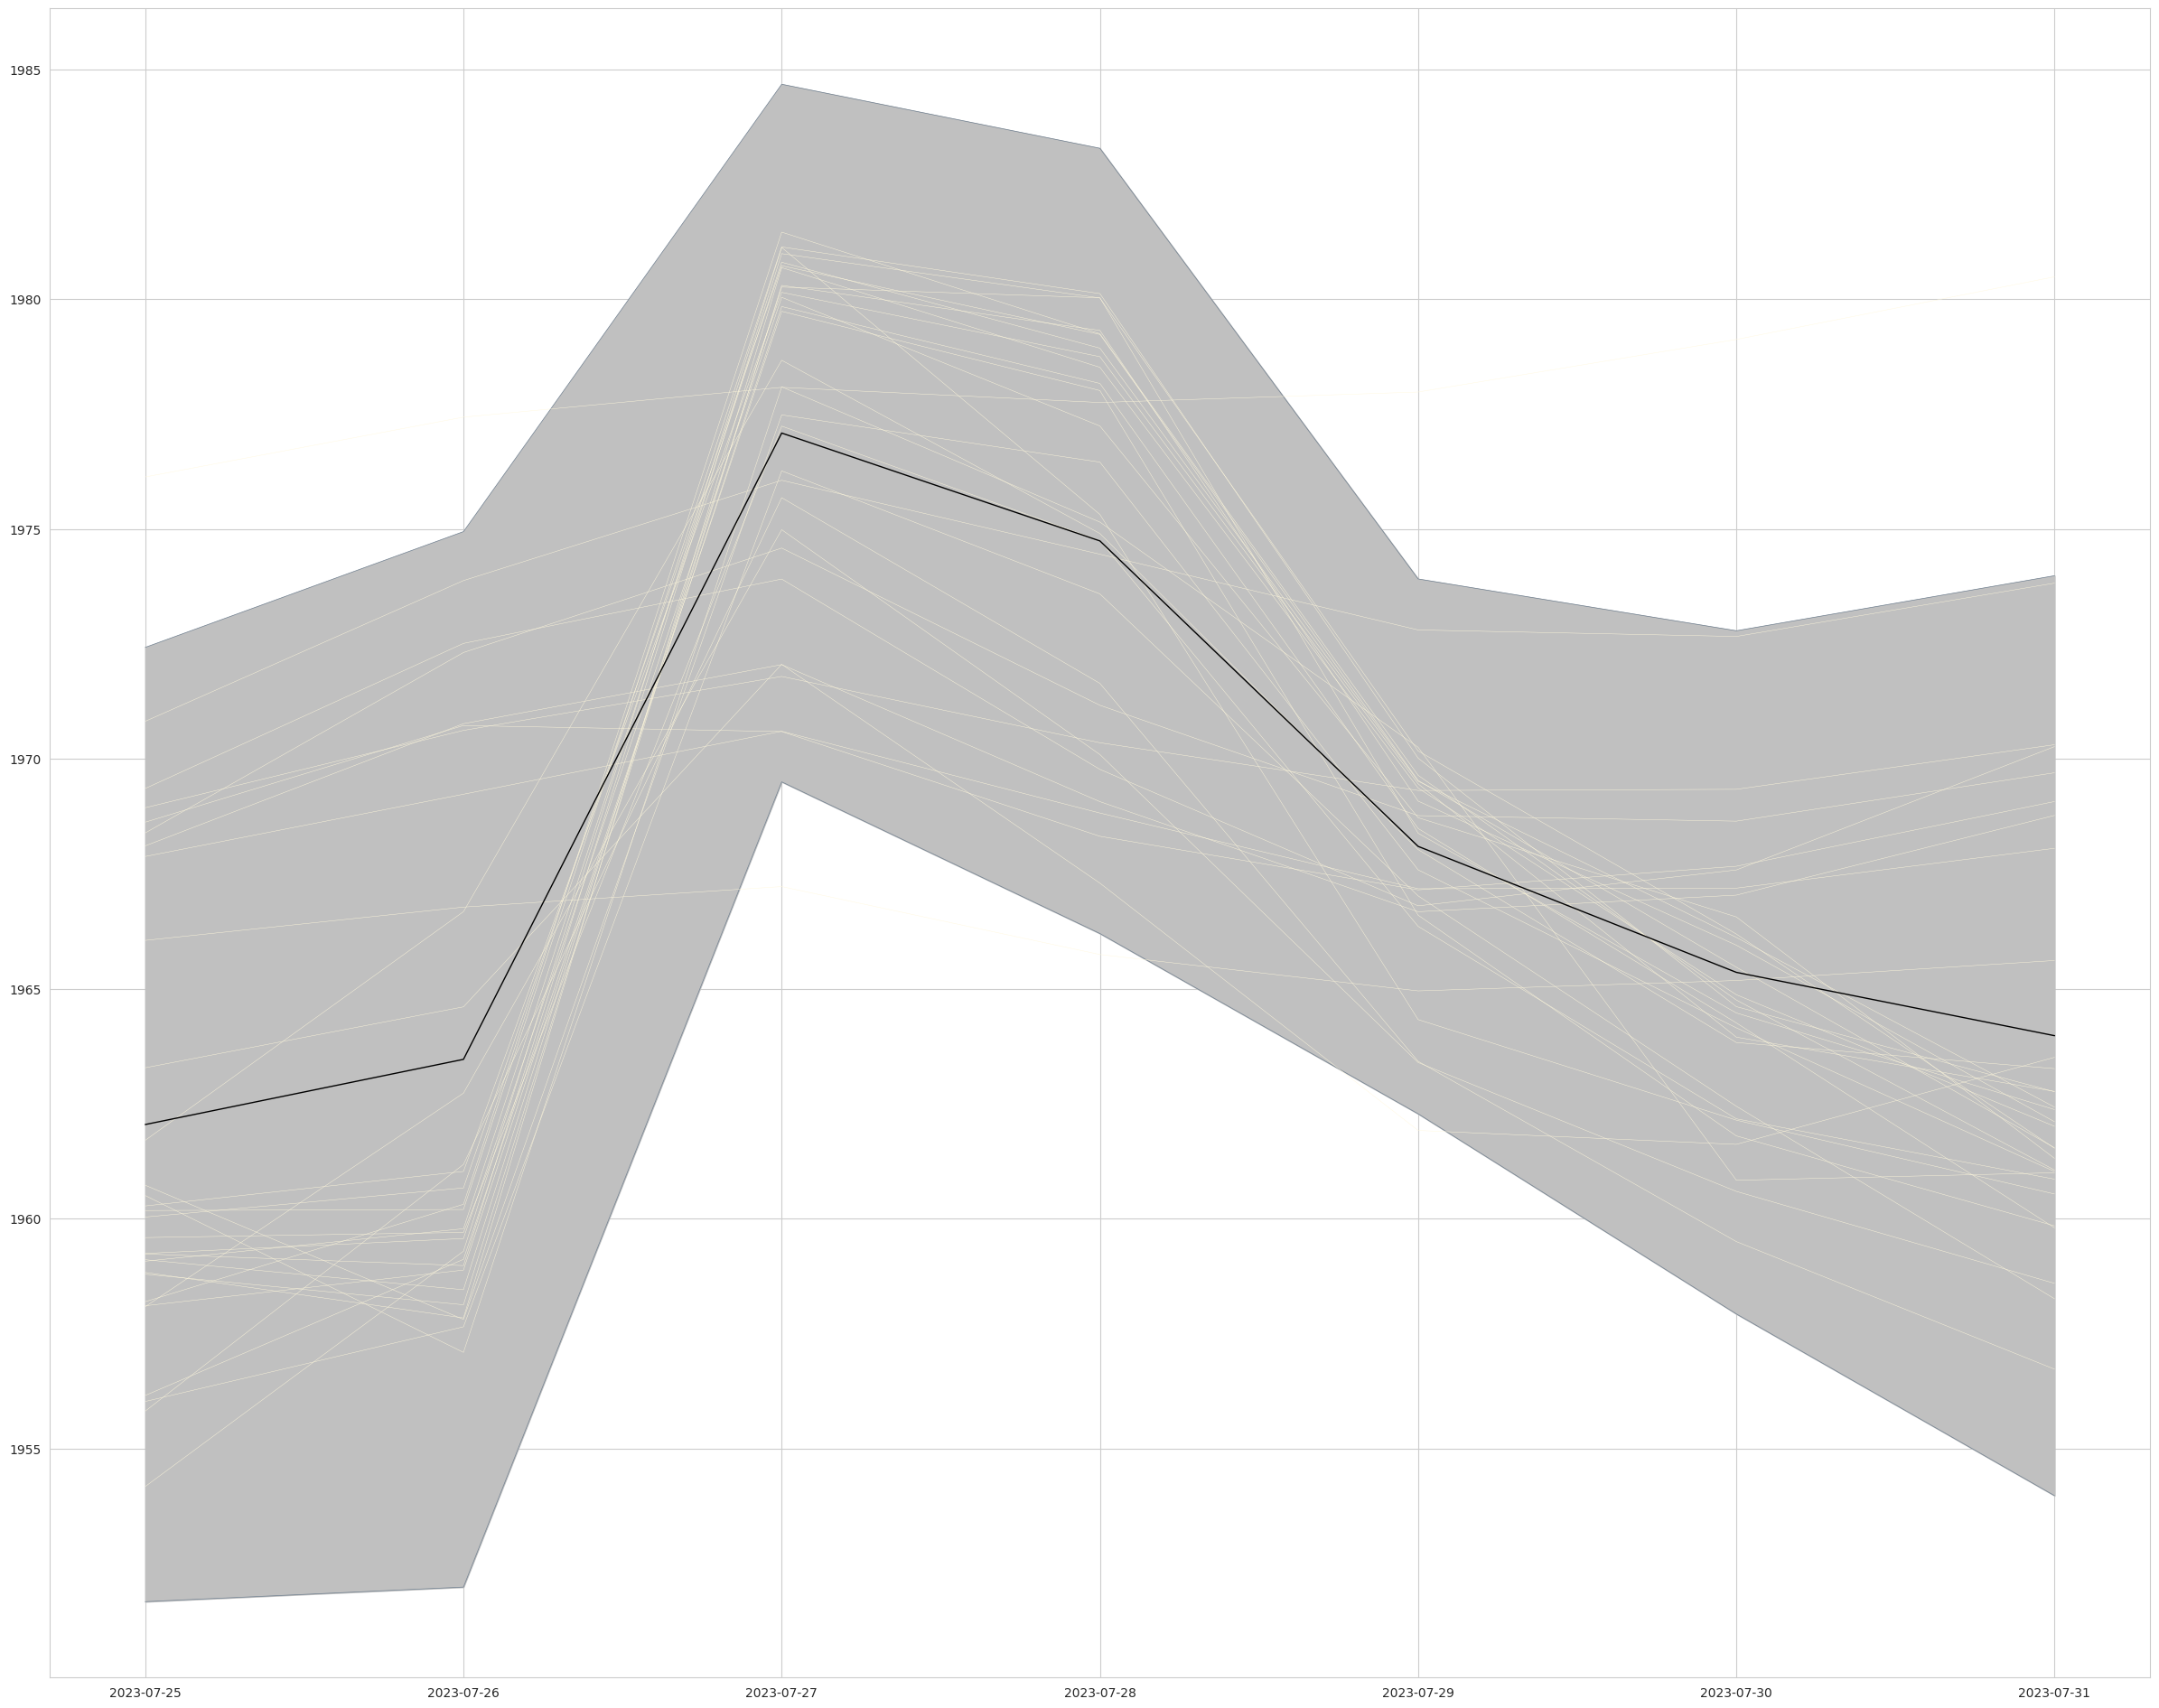

In [ ]:
fig, ax = plt.subplots(figsize=(30,24))
ax.plot(dt_index_extended[-7:], nbeats_upper_future[-7:], linewidth=.5, color='slategrey')
ax.plot(dt_index_extended[-7:], tf.reduce_mean(nbeats_future_predictions, axis=0)[-15:], linewidth=1, color='black', zorder=3)
ax.plot(dt_index_extended[-7:], nbeats_lower_future[-7:], linewidth=.5, color='slategrey')
# ax.plot(dt_index_extended[-7:], y_test[-8:], linewidth=1, color='crimson', zorder=3)

for idx, el in enumerate(nbeats_list_of_preds):
  ax.plot(dt_index_extended[-7:], nbeats_future_predictions[idx, -7:], linewidth=.3, color='cornsilk')

ax.fill_between(x=dt_index_extended[-7:], y1=nbeats_lower_future[-7:], y2=nbeats_upper_future[-7:], color='silver')

plt.show()

## 15. Model 9: Why timeseries prediction is biased? The turkey problem.

,Close
Date,
2000-08-30,273.899994
2000-08-31,278.299988
2000-09-01,277.000000
2000-09-05,275.799988
2000-09-06,274.200012
...,...
2023-07-18,1977.199951
2023-07-19,1977.500000
2023-07-20,1968.300049


In [ ]:
# Let's introduce a "turkey" data point to our data.
gold_close_turkey_df = gold_close_df.copy()
gold_close_turkey_df.iloc[-1]['Close'] = gold_close_turkey_df.iloc[-1]['Close'] / 100

In [ ]:
gold_close_turkey_df.tail()

,Close
Date,
2023-07-18,1977.199951
2023-07-19,1977.500000
2023-07-20,1968.300049
2023-07-21,1964.300049
2023-07-24,19.620000


In [ ]:
# Create
gold_close_turkey_df_windowed = gold_close_turkey_df.copy()
# Add windowed columns
for i in range(WINDOW_SIZE):
  gold_close_turkey_df_windowed[f'Close+{i+1}'] = gold_close_turkey_df_windowed['Close'].shift(periods=i+1)

gold_close_turkey_df_windowed = gold_close_turkey_df_windowed.dropna()

In [ ]:
gold_close_turkey_df_windowed.tail()

,Close,Close+1,Close+2,Close+3,Close+4,Close+5,Close+6,Close+7
Date,,,,,,,,
2023-07-18,1977.199951,1952.400024,1960.099976,1959.199951,1956.199951,1931.300049,1925.000000,1926.199951
2023-07-19,1977.500000,1977.199951,1952.400024,1960.099976,1959.199951,1956.199951,1931.300049,1925.000000
2023-07-20,1968.300049,1977.500000,1977.199951,1952.400024,1960.099976,1959.199951,1956.199951,1931.300049
2023-07-21,1964.300049,1968.300049,1977.500000,1977.199951,1952.400024,1960.099976,1959.199951,1956.199951
2023-07-24,19.620000,1964.300049,1968.300049,1977.500000,1977.199951,1952.400024,1960.099976,1959.199951


In [ ]:
turkey_features = gold_close_turkey_df_windowed.drop('Close', axis=1)
turkey_target = gold_close_turkey_df_windowed['Close']

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_turkey_train, X_turkey_test, y_turkey_train, y_turkey_test = train_test_split(turkey_features, turkey_target, test_size=0.2, shuffle=False)

In [ ]:
model_10 = tf.keras.Sequential([
    Dense(128, activation='relu'),
    Dense(1, activation='linear')
])

In [ ]:
model_10.compile(
    loss='mae',
    optimizer='adam',
    metrics=['mae', 'mse']
)

In [ ]:
model_10.build(input_shape=(1,7))

In [ ]:
model_10.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3772 (Dense)          (1, 128)                  1024      
                                                                 
 dense_3773 (Dense)          (1, 1)                    129       
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


In [ ]:
turkey_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=15,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)


In [ ]:
model_10.fit(
    X_turkey_train,
    y_turkey_train,
    epochs=100,
    verbose=0,
    batch_size=128,
    validation_data=(X_turkey_test, y_turkey_test),
    callbacks=[turkey_early_stopping],
)

In [ ]:
model_10.evaluate(X_turkey_test, y_turkey_test)

36/36 [==============================] - 0s 2ms/step - loss: 14.1977 - mae: 14.1977 - mse: 3622.6260


[14.197693824768066, 14.197693824768066, 3622.6259765625]

In [ ]:
turkey_preds = make_preds(model_10, X_turkey_test)

36/36 [==============================] - 0s 1ms/step


In [ ]:
turkey_results = produce_metrics(y_true=y_turkey_test, y_pred=tf.cast(turkey_preds, dtype=tf.float64))

In [ ]:
turkey_results

{'mae': 14.197691165512033,
 'mse': 3622.6259584849704,
 'rmse': 60.18825432328944,
 'mape': 9.36380453595253,
 'smape': 0.8897607529162838,
 'mase': nan}